# EXP03-v2: Prompt Engineering (with T+M Context)

- **Date**: 2026-02-10
- **Prerequisite**: EXP01-v2 (T+M chunking, Recall 0.7905) + EXP02-v2 (alpha=0.5, top_k=15 확정)
- **Goal**: T+M 컨텍스트 환경에서 프롬프트 전략별 답변 품질 재평가
- **Target Metrics**: Faithfulness(Primary), Answer Relevancy, Keyword Accuracy

## 변경 이력
- v1 (EXP03): V1 파이프라인(chunk=500, layout, alpha=0.3, top_k=15) 기반 프롬프트 비교
- v2: EXP01-v2 T+M 청킹 + EXP02-v2 확정 설정(alpha=0.5, top_k=15) 기반 재평가

## 1. 실험 설계 (Experiment Design)

### 1.1 실험 배경

EXP03(V1)에서 프롬프트 전략을 비교한 결과:
- `zero_shot_ko` 선정 (Faithfulness 0.9632)
- Context Recall ~0.77 천장 확인 → **프롬프트로 검색 품질 개선 불가**
- 이 진단으로 V2 라인 기획 → EXP01-v2에서 T+M 청킹으로 Recall 0.7905 달성

EXP03-v2는 **개선된 T+M 컨텍스트**에서 동일 프롬프트 전략을 재평가합니다:
- T+M 환경에서는 표 데이터가 별도 Markdown 청크로 검색됨 → 컨텍스트 품질 변화
- 메타데이터 prefix(`[페이지: N]`)가 포함된 컨텍스트 → 생성 품질에 영향 가능
- 검색 품질 향상(Recall 0.77→0.79)이 생성 품질에도 전이되는지 검증

### 1.2 고정 변수 (Controlled Variables) — from EXP01-v2 + EXP02-v2

| 변수 | 값 | 근거 |
|------|-----|------|
| Chunk Size | 500 | EXP01 최적값 |
| Chunk Overlap | 50 (10%) | 문맥 연속성 |
| Table Integration (T) | ON | EXP01-v2 Best |
| Metadata Enrichment (M) | ON | EXP01-v2 Best |
| Structure-aware (S) | OFF | T+M > S+T+M |
| Alpha (BM25 weight) | 0.5 | EXP02/EXP02-v2 확정 |
| Top-K | 15 | EXP02/EXP02-v2 확정 |
| Embedding | text-embedding-3-small | 비용 효율적 |
| Generation LLM | gpt-5-mini | EXP03과 동일 |

### 1.3 실험 변수 (Independent Variable)

| 전략 | 설명 |
|------|------|
| `zero_shot_en` | 영문 기본 프롬프트 (Baseline) |
| `zero_shot_ko` | 한국어 도메인 특화 프롬프트 |
| `few_shot_ko` | 한국어 + Few-shot 예시 2개 |
| `cot_ko` | 한국어 + Chain-of-Thought 추론 유도 |

### 1.4 가설 (Hypothesis)

1. **H1**: T+M 컨텍스트에서 전체적인 생성 품질(Faithfulness, Keyword Accuracy)이 V1 대비 향상될 것이다.
   - 근거: 검색 품질 개선(Recall 0.77→0.79)으로 LLM이 더 정확한 컨텍스트를 참조
2. **H2**: `zero_shot_ko`가 여전히 Faithfulness 최고일 것이나, 절대값은 V1(0.9632)보다 향상될 것이다.
3. **H3**: `cot_ko`의 Keyword Accuracy 우위가 T+M 환경에서도 유지될 것이다.
4. **H4**: 표 데이터 포함 질문에서 모든 전략의 Keyword Accuracy가 V1 대비 크게 개선될 것이다.

### 1.5 메트릭

| 메트릭 | 설명 | LLM 호출 |
|--------|------|----------|
| **Faithfulness** (Primary) | 답변이 검색 문맥에 근거하는 비율 | O |
| **Answer Relevancy** | 답변이 질문에 적절히 대응하는 정도 | O |
| **Context Recall** | 정답이 검색 청크에 포함되는 비율 | O |
| **Keyword Accuracy** | Ground Truth 키워드 포함 비율 (LLM-free) | X |

### 1.6 EXP03 vs EXP03-v2 비교 프레임

| 차이점 | EXP03 (V1) | EXP03-v2 |
|--------|-----------|----------|
| 청킹 | 기본 (layout only) | T+M (표+메타데이터) |
| Alpha | 0.3 | 0.5 |
| 인덱스 청크 수 | ~611 | ~1,005 |
| 컨텍스트 특성 | 텍스트만 | 텍스트 + 표 Markdown |
| Prerequisite Recall | 0.7667 | 0.7905 |

In [1]:
# ============================================================
# 2. Setup
# ============================================================
import os
import re
import gc
import json
import time
import shutil
import hashlib
import warnings
from datetime import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdfplumber

from datasets import Dataset
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langchain_community.retrievers import BM25Retriever

from ragas import evaluate
from ragas.metrics import Faithfulness, ResponseRelevancy, ContextRecall
from ragas.run_config import RunConfig

from bidflow.parsing.preprocessor import TextPreprocessor
from bidflow.eval.ragas_runner import RagasRunner, FixedTempChatOpenAI

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print('[OK] Setup complete')

[OK] Setup complete


C:\Users\c\AppData\Local\Temp\ipykernel_53216\352913278.py:30: DeprecationWarning: Importing Faithfulness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import Faithfulness
  from ragas.metrics import Faithfulness, ResponseRelevancy, ContextRecall
C:\Users\c\AppData\Local\Temp\ipykernel_53216\352913278.py:30: DeprecationWarning: Importing ResponseRelevancy from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import ResponseRelevancy
  from ragas.metrics import Faithfulness, ResponseRelevancy, ContextRecall
C:\Users\c\AppData\Local\Temp\ipykernel_53216\352913278.py:30: DeprecationWarning: Importing ContextRecall from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import ContextRecall
  fr

In [2]:
# ============================================================
# 3. Config & Data Load
# ============================================================
EXP01V2_REPORT_PATH = '../data/experiments/exp01v2_report.json'
EXP03_REPORT_PATH = '../data/experiments/exp03_report.json'
GOLDEN_TESTSET_PATH = '../data/experiments/golden_testset.csv'
CHROMA_EXP_PATH = '../data/chroma_exp/exp03v2'

OUT_REPORT_PATH = '../data/experiments/exp03v2_report.json'
OUT_CSV_PATH = '../data/experiments/exp03v2_results.csv'
OUT_FIG_PATH = '../data/experiments/exp03v2_results.png'

EMBED_MODEL = 'text-embedding-3-small'
GEN_MODEL = 'gpt-5-mini'

# ===== EXP01-v2 Prerequisite 로드 =====
print('=' * 60)
print('1. EXP01-v2 Prerequisite 로드')
print('=' * 60)

if not os.path.exists(EXP01V2_REPORT_PATH):
    raise FileNotFoundError(f'EXP01-v2 report not found: {EXP01V2_REPORT_PATH}')

with open(EXP01V2_REPORT_PATH, 'r', encoding='utf-8') as f:
    exp01v2 = json.load(f)

exp01v2_best = exp01v2['best_config']
exp01v2_fixed = exp01v2['meta']['fixed_params']

CHUNK_SIZE = int(exp01v2_fixed.get('chunk_size', 500))
CHUNK_OVERLAP = int(CHUNK_SIZE * 0.1)
TABLE_STRATEGY = exp01v2_fixed.get('table_strategy', 'layout')
ALPHA = float(exp01v2_fixed.get('alpha', 0.5))  # BM25 weight in RRF
TOP_K = int(exp01v2_fixed.get('top_k', 15))

# T+M config 파싱
config_str = str(exp01v2_best['config'])
parts = set(config_str.split('+'))
USE_TABLES = 'T' in parts
USE_METADATA = 'M' in parts

EXP01V2_RECALL = float(exp01v2_best['context_recall'])

print(f'  Config: {config_str}, Recall: {EXP01V2_RECALL:.4f}')
print(f'  Chunk: {CHUNK_SIZE}, Overlap: {CHUNK_OVERLAP}')
print(f'  T={USE_TABLES}, M={USE_METADATA}')
print(f'  Alpha: {ALPHA}, Top-K: {TOP_K}')

# ===== EXP03(V1) 결과 로드 (비교용) =====
print(f'\n{"=" * 60}')
print('2. EXP03(V1) 결과 로드 (비교 Baseline)')
print('=' * 60)

exp03_baseline = {}
if os.path.exists(EXP03_REPORT_PATH):
    with open(EXP03_REPORT_PATH, 'r', encoding='utf-8') as f:
        exp03 = json.load(f)
    for r in exp03['results']:
        exp03_baseline[r['strategy']] = {
            'faithfulness': r['faithfulness'],
            'answer_relevancy': r['answer_relevancy'],
            'context_recall': r['context_recall'],
            'keyword_accuracy': r['keyword_accuracy'],
        }
    print(f'  EXP03 결과 {len(exp03_baseline)}개 전략 로드')
    for k, v in exp03_baseline.items():
        print(f'    {k}: faith={v["faithfulness"]:.4f}, kw_acc={v["keyword_accuracy"]:.4f}')
else:
    print('  [Warning] EXP03 리포트 없음. 비교 없이 진행.')

# ===== Golden Testset =====
print(f'\n{"=" * 60}')
print('3. Golden Testset & Sample PDF')
print('=' * 60)

golden_df = pd.read_csv(GOLDEN_TESTSET_PATH)
golden_df = golden_df[~golden_df['ground_truth'].str.contains(r'\[여기에', na=False)]
print(f'  Test cases: {len(golden_df)}')

# Sample PDF
sample_file = exp01v2['meta'].get('sample_file')
if sample_file and os.path.exists(sample_file):
    SAMPLE_FILE = sample_file
else:
    data_dir = '../data/raw/files'
    pdfs = [f for f in os.listdir(data_dir) if f.lower().endswith('.pdf')]
    SAMPLE_FILE = os.path.join(data_dir, pdfs[0])

print(f'  PDF: {os.path.basename(SAMPLE_FILE)}')

1. EXP01-v2 Prerequisite 로드
  Config: T+M, Recall: 0.7905
  Chunk: 500, Overlap: 50
  T=True, M=True
  Alpha: 0.5, Top-K: 15

2. EXP03(V1) 결과 로드 (비교 Baseline)
  EXP03 결과 4개 전략 로드
    zero_shot_en: faith=0.8647, kw_acc=0.4403
    zero_shot_ko: faith=0.9632, kw_acc=0.4916
    few_shot_ko: faith=0.9111, kw_acc=0.4110
    cot_ko: faith=nan, kw_acc=0.6065

3. Golden Testset & Sample PDF
  Test cases: 30
  PDF: 고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf


## 4. 인덱싱 & 사전 검색

EXP01-v2 T+M 설정으로 인덱스를 구축하고, 모든 질문에 대해 **1회 검색**을 수행합니다.
4가지 프롬프트 전략에 동일한 context를 제공하여 **생성 단계만 비교**합니다.

### T+M 인덱싱 전략 (EXP02-v2와 동일)
- **텍스트 청크**: RecursiveCharacterTextSplitter (500자, overlap 50)
- **테이블 청크** (T): pdfplumber 테이블을 Markdown으로 변환하여 별도 인덱싱
- **메타데이터** (M): `[페이지: N]` prefix + `page_no`, `content_type` 메타
- **RAGAS 평가 시**: `strip_meta_prefix()`로 prefix 제거하여 과대평가 방지

In [3]:
def robust_rmtree(path):
    if not os.path.exists(path): return
    for _ in range(5):
        try: shutil.rmtree(path); return
        except PermissionError: gc.collect(); time.sleep(1)
        except Exception: return


def table_to_markdown(table_data):
    if not table_data or len(table_data) < 1:
        return ''
    max_cols = max(len(row) for row in table_data)
    rows = []
    for row in table_data:
        clean = []
        for cell in row:
            c = str(cell).strip().replace('\n', ' ').replace('|', '/') if cell else ''
            clean.append(c if c != 'None' else '')
        while len(clean) < max_cols:
            clean.append('')
        rows.append(clean)
    if all(all(c == '' for c in row) for row in rows):
        return ''
    lines = []
    lines.append('| ' + ' | '.join(rows[0]) + ' |')
    lines.append('| ' + ' | '.join(['---'] * max_cols) + ' |')
    for row in rows[1:]:
        lines.append('| ' + ' | '.join(row) + ' |')
    return '\n'.join(lines)


def get_page_for_position(char_idx, page_map):
    for start, end, page_no in page_map:
        if start <= char_idx < end:
            return page_no
    return 1


def strip_meta_prefix(text):
    """[페이지: N] 및 [표] prefix 제거 (RAGAS 과대평가 방지)"""
    if text.startswith('[페이지:'):
        nl = text.find('\n')
        if nl >= 0:
            text = text[nl + 1:]
    if text.startswith('[표]\n'):
        text = text[4:]
    return text


def _doc_key(doc):
    meta = getattr(doc, 'metadata', {}) or {}
    chunk_id = meta.get('chunk_id')
    if chunk_id:
        return f'chunk:{chunk_id}'
    digest = hashlib.sha1(doc.page_content.encode('utf-8')).hexdigest()[:16]
    return f'fallback:{digest}'


def rrf_merge(bm25_docs, vector_docs, w_bm25, w_vector, top_k, k=60):
    scores = defaultdict(float)
    doc_map = {}
    for rank, doc in enumerate(bm25_docs):
        key = _doc_key(doc)
        scores[key] += w_bm25 * (1 / (rank + k))
        doc_map[key] = doc
    for rank, doc in enumerate(vector_docs):
        key = _doc_key(doc)
        scores[key] += w_vector * (1 / (rank + k))
        if key not in doc_map:
            doc_map[key] = doc
    sorted_keys = sorted(scores.keys(), key=lambda x: scores[x], reverse=True)
    return [doc_map[k_] for k_ in sorted_keys[:top_k]]


def build_documents(sample_file, chunk_size, chunk_overlap,
                    use_tables=True, use_metadata=True):
    """T+M 인덱싱 (EXP02-v2와 동일 구현)"""
    preprocessor = TextPreprocessor()

    with pdfplumber.open(sample_file) as pdf:
        page_texts = []
        page_tables = []
        for i, page in enumerate(pdf.pages):
            raw_text = page.extract_text(layout=True) or ''
            norm = preprocessor.normalize(raw_text)
            page_texts.append((i + 1, norm))
            if use_tables:
                tables = page.extract_tables() or []
                for j, tbl in enumerate(tables):
                    if tbl and any(any(cell for cell in row) for row in tbl):
                        page_tables.append((i + 1, j, tbl))

    full_text = ''
    page_map = []
    for page_no, text in page_texts:
        start = len(full_text)
        full_text += text + '\n\n'
        end = len(full_text)
        page_map.append((start, end, page_no))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap,
        separators=['\n\n', '\n', '.', ' ', '']
    )
    plain_chunks = splitter.split_text(full_text)

    docs = []
    search_from = 0
    for i, c in enumerate(plain_chunks):
        idx = full_text.find(c, search_from)
        if idx < 0:
            idx = full_text.find(c[:80], search_from)
        if idx < 0:
            idx = max(search_from, 0)
        page_no = get_page_for_position(idx, page_map)
        text = f'[페이지: {page_no}]\n{c}' if use_metadata else c
        meta = {'chunk_id': f'text_{i}', 'page_no': page_no, 'content_type': 'text'}
        docs.append(Document(page_content=text, metadata=meta))
        search_from = idx + 1

    if use_tables:
        t_count = 0
        for pg_no, t_idx, tbl in page_tables:
            md = table_to_markdown(tbl)
            if md and len(md.strip()) > 30:
                text = f'[페이지: {pg_no}]\n[표]\n{md}' if use_metadata else f'[표]\n{md}'
                meta = {'chunk_id': f'table_{pg_no}_{t_idx}', 'page_no': pg_no, 'content_type': 'table'}
                docs.append(Document(page_content=text, metadata=meta))
                t_count += 1
        print(f'  Table chunks: +{t_count}')

    return docs


print('[OK] Helper functions ready')

[OK] Helper functions ready


In [4]:
# ============================================================
# 인덱스 구축 + 사전 검색 (1회)
# ============================================================
robust_rmtree(CHROMA_EXP_PATH)
os.makedirs(CHROMA_EXP_PATH, exist_ok=True)

print('=' * 60)
print(f'인덱스 구축: T={USE_TABLES}, M={USE_METADATA}')
print('=' * 60)

t0 = time.perf_counter()
docs = build_documents(
    SAMPLE_FILE, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP,
    use_tables=USE_TABLES, use_metadata=USE_METADATA,
)
parse_time = time.perf_counter() - t0

embeddings = OpenAIEmbeddings(model=EMBED_MODEL)
vector_db = Chroma(
    persist_directory=CHROMA_EXP_PATH,
    embedding_function=embeddings,
    collection_name='exp03v2_prompt',
)

t1 = time.perf_counter()
vector_db.add_documents(docs)
index_time = time.perf_counter() - t1
print(f'[OK] docs={len(docs)}, parse={parse_time:.2f}s, index={index_time:.2f}s')

# ===== 사전 검색 (모든 전략에 동일 context 제공) =====
print(f'\n{"=" * 60}')
print(f'사전 검색: alpha={ALPHA}, top_k={TOP_K}')
print('=' * 60)

vector_retriever = vector_db.as_retriever(search_kwargs={'k': TOP_K * 2})
bm25_retriever = BM25Retriever.from_documents(docs)
bm25_retriever.k = TOP_K * 2

pre_retrieved = []
for _, row in golden_df.iterrows():
    q = row['question']
    gt = str(row['ground_truth'])
    bm25_docs = bm25_retriever.invoke(q)
    vec_docs = vector_retriever.invoke(q)
    merged = rrf_merge(bm25_docs, vec_docs,
                       w_bm25=ALPHA, w_vector=1.0 - ALPHA, top_k=TOP_K)

    # display: 원본 (prefix 포함), raw: prefix 제거 (RAGAS용)
    contexts_display = [d.page_content for d in merged]
    contexts_raw = [strip_meta_prefix(d.page_content) for d in merged]

    pre_retrieved.append({
        'question': q,
        'ground_truth': gt,
        'contexts_display': contexts_display,
        'contexts_raw': contexts_raw,
        'category': row.get('category', ''),
        'difficulty': row.get('difficulty', ''),
    })

print(f'[OK] {len(pre_retrieved)}개 질문 사전 검색 완료')

인덱스 구축: T=True, M=True
  Table chunks: +414
[OK] docs=1005, parse=25.78s, index=5.96s

사전 검색: alpha=0.5, top_k=15
[OK] 30개 질문 사전 검색 완료


## 5. 프롬프트 전략 정의

EXP03과 동일한 4가지 전략을 사용합니다. 검색 결과(context)는 동일하며, 프롬프트만 변경합니다.

**생성 시 context로 `contexts_raw`(prefix 제거본) 사용**: LLM이 `[페이지: N]` 형식 정보에 혼동되지 않도록.

In [5]:
PROMPT_STRATEGIES = {
    'zero_shot_en': (
        'Baseline (영문 Zero-shot)',
        """Answer the question based only on the following context:

{context}

Question: {question}

Answer:"""
    ),

    'zero_shot_ko': (
        '한국어 Zero-shot',
        """당신은 RFP(제안요청서) 분석 전문가입니다.
주어진 문맥(Context)만을 근거로 질문에 답변하세요.

## 규칙
- 문맥에 없는 정보는 절대 추측하지 말고 "확인 불가"라고 답하세요.
- 숫자, 날짜, 금액 등 정량 정보는 원문 그대로 인용하세요.
- 답변은 간결하게 핵심만 적으세요.

## 문맥
{context}

## 질문
{question}

## 답변"""
    ),

    'few_shot_ko': (
        '한국어 Few-shot (2 examples)',
        """당신은 RFP(제안요청서) 분석 전문가입니다.
주어진 문맥(Context)만을 근거로 질문에 답변하세요.

## 규칙
- 문맥에 없는 정보는 절대 추측하지 말고 "확인 불가"라고 답하세요.
- 숫자, 날짜, 금액 등 정량 정보는 원문 그대로 인용하세요.
- 답변은 간결하게 핵심만 적으세요.

## 답변 예시
질문: 발주 기관은 어디인가?
답변: 고려대학교

질문: 제안서 분량 제한이 있는가?
답변: 확인 불가

## 문맥
{context}

## 질문
{question}

## 답변"""
    ),

    'cot_ko': (
        '한국어 Chain-of-Thought',
        """당신은 RFP(제안요청서) 분석 전문가입니다.
주어진 문맥(Context)만을 근거로 질문에 답변하세요.

## 규칙
- 문맥에 없는 정보는 절대 추측하지 말고 "확인 불가"라고 답하세요.
- 숫자, 날짜, 금액 등 정량 정보는 원문 그대로 인용하세요.

## 사고 과정
1. 질문이 요구하는 핵심 정보가 무엇인지 파악하세요.
2. 문맥에서 해당 정보가 포함된 부분을 찾으세요.
3. 찾은 정보를 바탕으로 간결하게 답변하세요.
4. 정보를 찾을 수 없으면 "확인 불가"라고 답하세요.

## 문맥
{context}

## 질문
{question}

## 단계별 분석 후 최종 답변"""
    ),
}

print(f'[OK] {len(PROMPT_STRATEGIES)}개 프롬프트 전략 정의')
for key, (desc, _) in PROMPT_STRATEGIES.items():
    print(f'  - {key}: {desc}')

[OK] 4개 프롬프트 전략 정의
  - zero_shot_en: Baseline (영문 Zero-shot)
  - zero_shot_ko: 한국어 Zero-shot
  - few_shot_ko: 한국어 Few-shot (2 examples)
  - cot_ko: 한국어 Chain-of-Thought


## 6. 평가 함수 및 실험 실행

### RunConfig 개선 (EXP03/EXP02-v2 경험 반영)
- `timeout=300` (기존 180 → TimeoutError 방지)
- `max_workers=2` (기존 4 → API rate limit 안정화)
- EXP03에서 `cot_ko` Faithfulness NaN 발생 → 이번에는 안정적 측정 기대

In [6]:
def calculate_keyword_accuracy(answers, ground_truths, threshold=0.4):
    """LLM-free 키워드 매칭 정확도"""
    scores = []
    for answer, gt in zip(answers, ground_truths):
        gt_words = [w for w in gt.lower().split() if len(w) > 1]
        if not gt_words:
            scores.append(0.0)
            continue
        answer_lower = answer.lower()
        matched = sum(1 for w in gt_words if w in answer_lower)
        scores.append(matched / len(gt_words))
    return float(np.mean(scores))


def extract_metric(val):
    if isinstance(val, (list, tuple)): return float(np.mean(val))
    if hasattr(val, 'mean'): return float(val.mean())
    return float(val) if val is not None else 0.0


ragas_runner = RagasRunner()
run_cfg = RunConfig(timeout=300, max_retries=5, max_wait=300, max_workers=2)

print(f'[OK] RunConfig: timeout=300, max_workers=2 (EXP03 대비 안정화)')

[OK] RunConfig: timeout=300, max_workers=2 (EXP03 대비 안정화)


In [7]:
def run_single_experiment(strategy_key, strategy_desc, prompt_template, pre_retrieved):
    """단일 프롬프트 전략: 답변 생성 + RAGAS 평가"""
    print(f'\n{"=" * 60}')
    print(f'[Experiment] {strategy_key}: {strategy_desc}')
    print(f'{"=" * 60}')

    start_time = time.perf_counter()

    # 1. LLM 체인 구성
    llm = FixedTempChatOpenAI(model=GEN_MODEL, timeout=180, max_retries=3)
    prompt = ChatPromptTemplate.from_template(prompt_template)
    chain = prompt | llm | StrOutputParser()

    # 2. 답변 생성 (context_raw 사용 — prefix 제거본)
    questions, ground_truths, contexts_list, answers = [], [], [], []

    for item in pre_retrieved:
        q = item['question']
        gt = item['ground_truth']
        ctx = item['contexts_raw']  # prefix 제거된 context
        context_text = '\n\n'.join(ctx)

        try:
            answer = chain.invoke({'context': context_text, 'question': q})
        except Exception as e:
            print(f'  Generation Error ({q[:20]}...): {e}')
            answer = 'Error'

        questions.append(q)
        ground_truths.append(gt)
        contexts_list.append(ctx)
        answers.append(answer)

    gen_time = time.perf_counter() - start_time
    print(f'  답변 생성 완료: {len(answers)}개 ({gen_time:.2f}s)')

    # 3. Keyword Accuracy (LLM-free)
    kw_accuracy = calculate_keyword_accuracy(answers, ground_truths)
    print(f'  Keyword Accuracy: {kw_accuracy:.4f}')

    # 4. RAGAS 평가
    ragas_start = time.perf_counter()
    try:
        dataset = Dataset.from_dict({
            'user_input': questions,
            'response': answers,
            'retrieved_contexts': contexts_list,
            'reference': ground_truths,
        })

        eval_result = evaluate(
            dataset,
            metrics=[
                Faithfulness(llm=ragas_runner.llm),
                ResponseRelevancy(llm=ragas_runner.llm, embeddings=ragas_runner.embeddings),
                ContextRecall(llm=ragas_runner.llm),
            ],
            llm=ragas_runner.llm,
            embeddings=ragas_runner.embeddings,
            raise_exceptions=False,
            run_config=run_cfg,
        )

        faithfulness = extract_metric(eval_result['faithfulness'])
        relevancy = extract_metric(eval_result['answer_relevancy'])
        ctx_recall = extract_metric(eval_result['context_recall'])
    except Exception as e:
        print(f'  RAGAS Error: {e}')
        faithfulness, relevancy, ctx_recall = 0.0, 0.0, 0.0

    ragas_time = time.perf_counter() - ragas_start
    total_time = time.perf_counter() - start_time

    print(f'  Faithfulness:     {faithfulness:.4f}')
    print(f'  Answer Relevancy: {relevancy:.4f}')
    print(f'  Context Recall:   {ctx_recall:.4f}')
    print(f'  Time: {total_time:.2f}s (gen={gen_time:.2f}s, ragas={ragas_time:.2f}s)')

    # 5. 샘플 출력
    print(f'\n  [Sample Answers]')
    for i in range(min(3, len(answers))):
        print(f'  Q: {questions[i][:40]}...')
        print(f'  A: {answers[i][:80]}...')
        print(f'  GT: {ground_truths[i][:80]}')
        print()

    return {
        'strategy': strategy_key,
        'description': strategy_desc,
        'faithfulness': faithfulness,
        'answer_relevancy': relevancy,
        'context_recall': ctx_recall,
        'keyword_accuracy': kw_accuracy,
        'gen_time': float(gen_time),
        'ragas_time': float(ragas_time),
        'latency_total': float(total_time),
        'answers': answers,
    }

In [8]:
# ===== 실험 실행 =====
results = []

print(f'\n{"=" * 60}')
print(f'실험 시작: {len(PROMPT_STRATEGIES)}개 전략, RunConfig(timeout=300, workers=2)')
print('=' * 60)

completed = 0
for key, (desc, template) in PROMPT_STRATEGIES.items():
    try:
        result = run_single_experiment(key, desc, template, pre_retrieved)
        results.append(result)
        completed += 1
        print(f'  [{completed}/{len(PROMPT_STRATEGIES)}] 완료')
    except Exception as e:
        print(f'  Error in {key}: {e}')
        import traceback
        traceback.print_exc()

print(f'\n{"=" * 60}')
print(f'모든 실험 완료! ({completed}/{len(PROMPT_STRATEGIES)} 성공)')
print('=' * 60)


실험 시작: 4개 전략, RunConfig(timeout=300, workers=2)

[Experiment] zero_shot_en: Baseline (영문 Zero-shot)
  답변 생성 완료: 30개 (309.40s)
  Keyword Accuracy: 0.4352


Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


  Faithfulness:     0.9229
  Answer Relevancy: 0.5888
  Context Recall:   0.7333
  Time: 1605.08s (gen=309.40s, ragas=1295.68s)

  [Sample Answers]
  Q: 본 사업의 프로젝트 명은 무엇인가?...
  A: 제공된 문서·발췌본에는 본 사업의 프로젝트 명이 명시되어 있지 않습니다....
  GT: 고려대학교 차세대 포털·학사 정보시스템 구축 사업

  Q: 사업의 수행 기간은 얼마인가?...
  A: 제공된 문서에는 구체적 기간이 기재되어 있지 않습니다. 계약서에는 "계약 기간 : 년 월 일 ~ 년 월 일"으로 표시(플레이스홀더)되어 있을 뿐...
  GT: 계약 체결일로부터 24개월

  Q: 입찰 참가 자격 중 실적 관련 요구사항은?...
  A: 실적(사업수행 실적) 관련 요구사항은 다음과 같습니다.

- 제출서류
  - 주요사업 실적(서식 5), 사업 실적 증명서(서식 6) 등 실적 관...
  GT: 최근 3년간 유사 사업 수행 금액이 입찰 금액 대비 일정 비율 이상이어야 함 (세부 기준 공고서 참조)

  [1/4] 완료

[Experiment] zero_shot_ko: 한국어 Zero-shot
  답변 생성 완료: 30개 (350.18s)
  Keyword Accuracy: 0.4922


Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

  Faithfulness:     0.9524
  Answer Relevancy: 0.4133
  Context Recall:   0.7333
  Time: 1532.89s (gen=350.18s, ragas=1182.71s)

  [Sample Answers]
  Q: 본 사업의 프로젝트 명은 무엇인가?...
  A: 확인 불가...
  GT: 고려대학교 차세대 포털·학사 정보시스템 구축 사업

  Q: 사업의 수행 기간은 얼마인가?...
  A: 확인 불가 — 문서의 "계약 기간 : 년 월 일 ~ 년 월 일"이 비어 있어 사업 수행 기간이 명시되어 있지 않습니다....
  GT: 계약 체결일로부터 24개월

  Q: 입찰 참가 자격 중 실적 관련 요구사항은?...
  A: 입찰 참가 자격(가. 참가 자격) 항목에는 실적 관련 요구사항이 명시되어 있지 않음. 확인 불가.

참고로 문맥에는 하도급인에 대한 실적 평가 ...
  GT: 최근 3년간 유사 사업 수행 금액이 입찰 금액 대비 일정 비율 이상이어야 함 (세부 기준 공고서 참조)

  [2/4] 완료

[Experiment] few_shot_ko: 한국어 Few-shot (2 examples)
  답변 생성 완료: 30개 (298.34s)
  Keyword Accuracy: 0.4161


Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

  Faithfulness:     0.9578
  Answer Relevancy: 0.4038
  Context Recall:   0.6667
  Time: 1316.46s (gen=298.34s, ragas=1018.12s)

  [Sample Answers]
  Q: 본 사업의 프로젝트 명은 무엇인가?...
  A: 확인 불가...
  GT: 고려대학교 차세대 포털·학사 정보시스템 구축 사업

  Q: 사업의 수행 기간은 얼마인가?...
  A: 확인 불가...
  GT: 계약 체결일로부터 24개월

  Q: 입찰 참가 자격 중 실적 관련 요구사항은?...
  A: 입찰 참가 자격 항목에는 실적 요구사항이 명시되어 있지 않음. 다만 하도급 적정성 판단에서의 실적 관련 평가기준은 다음과 같음:

- "하수급인...
  GT: 최근 3년간 유사 사업 수행 금액이 입찰 금액 대비 일정 비율 이상이어야 함 (세부 기준 공고서 참조)

  [3/4] 완료

[Experiment] cot_ko: 한국어 Chain-of-Thought
  답변 생성 완료: 30개 (496.59s)
  Keyword Accuracy: 0.5942


Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


  Faithfulness:     0.7360
  Answer Relevancy: 0.5619
  Context Recall:   0.7000
  Time: 1993.04s (gen=496.59s, ragas=1496.45s)

  [Sample Answers]
  Q: 본 사업의 프로젝트 명은 무엇인가?...
  A: 단계별 분석 요약:
1) 핵심정보: 본 사업의 "프로젝트 명" 확인.  
2) 문맥 검색: 제공된 문서 내에서 '프로젝트 명', '사업명' 등 ...
  GT: 고려대학교 차세대 포털·학사 정보시스템 구축 사업

  Q: 사업의 수행 기간은 얼마인가?...
  A: 확인 불가.

문서에는 "계약 기간 : 년 월 일 ~ 년 월 일"로 기재되어 있어 구체적 수행기간이 명시되어 있지 않습니다. (참고: 인수인계 ...
  GT: 계약 체결일로부터 24개월

  Q: 입찰 참가 자격 중 실적 관련 요구사항은?...
  A: 분석
1) 질문의 핵심: "입찰 참가 자격 중 실적 관련 요구사항"이 무엇인지 파악해야 함.  
2) 문맥 검색 결과:
   - "3. 사업자 ...
  GT: 최근 3년간 유사 사업 수행 금액이 입찰 금액 대비 일정 비율 이상이어야 함 (세부 기준 공고서 참조)

  [4/4] 완료

모든 실험 완료! (4/4 성공)


## 7. 결과 분석 (Analysis)

### 분석 관점
1. **전략 간 비교**: 4가지 프롬프트 전략의 메트릭 비교
2. **V1 대비 개선**: EXP03(V1) 대비 각 메트릭의 변화량
3. **T+M 컨텍스트 효과**: 검색 품질 개선이 생성 품질에 전이되었는지

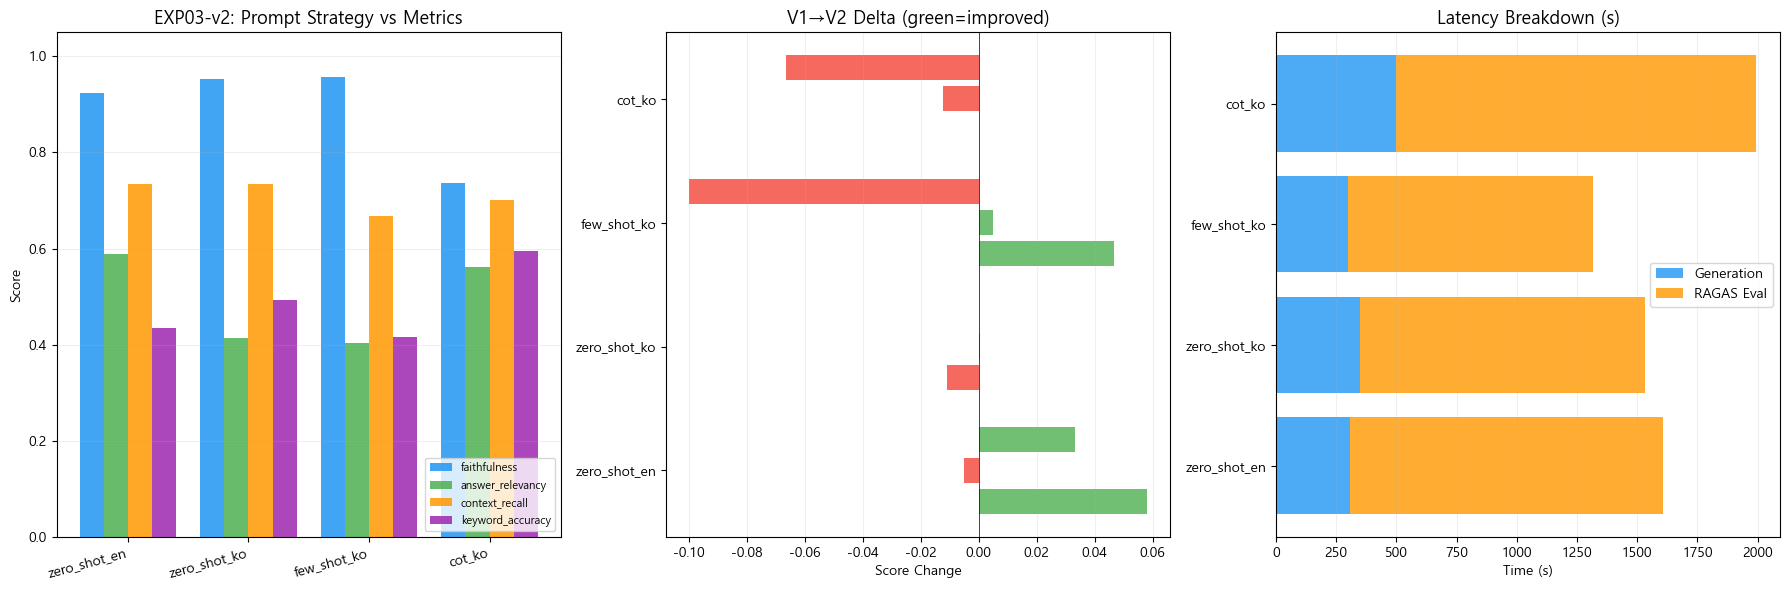


[EXP03-v2 Results]
    strategy  faithfulness  answer_relevancy  context_recall  keyword_accuracy  latency_total
zero_shot_en      0.922945          0.588816        0.733333          0.435182    1605.075915
zero_shot_ko      0.952369          0.413263        0.733333          0.492194    1532.886511
 few_shot_ko      0.957778          0.403794        0.666667          0.416084    1316.457506
      cot_ko      0.735953          0.561857        0.700000          0.594217    1993.044514

[V1 vs V2 Comparison]
Strategy         Metric                     V1       V2    Delta
--------------------------------------------------------------
zero_shot_en     faithfulness           0.8647   0.9229 + 0.0582
zero_shot_en     keyword_accuracy       0.4403   0.4352 -0.0052
zero_shot_en     context_recall         0.7000   0.7333 + 0.0333
zero_shot_ko     faithfulness           0.9632   0.9524 -0.0109
zero_shot_ko     keyword_accuracy       0.4916   0.4922 + 0.0006
zero_shot_ko     context_recall     

In [9]:
df_results = pd.DataFrame([{k: v for k, v in r.items() if k != 'answers'} for r in results])

if not df_results.empty:
    # ===== 1. 메트릭 비교 차트 =====
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1-1. 주요 메트릭 비교
    metrics_cols = ['faithfulness', 'answer_relevancy', 'context_recall', 'keyword_accuracy']
    x = np.arange(len(df_results))
    width = 0.2
    colors = ['#2196F3', '#4CAF50', '#FF9800', '#9C27B0']

    for i, col in enumerate(metrics_cols):
        axes[0].bar(x + i * width, df_results[col], width,
                    label=col, color=colors[i], alpha=0.85)
    axes[0].set_xticks(x + width * 1.5)
    axes[0].set_xticklabels(df_results['strategy'], rotation=15, ha='right')
    axes[0].set_title('EXP03-v2: Prompt Strategy vs Metrics', fontsize=13)
    axes[0].set_ylabel('Score')
    axes[0].legend(loc='lower right', fontsize=8)
    axes[0].grid(True, alpha=0.2, axis='y')
    axes[0].set_ylim(0, 1.05)

    # 1-2. V1 대비 변화 (delta)
    if exp03_baseline:
        delta_metrics = ['faithfulness', 'keyword_accuracy', 'context_recall']
        for i, col in enumerate(delta_metrics):
            deltas = []
            labels = []
            for _, row in df_results.iterrows():
                s = row['strategy']
                if s in exp03_baseline:
                    v1_val = exp03_baseline[s].get(col, 0)
                    v2_val = row[col]
                    if np.isnan(v1_val) or np.isnan(v2_val):
                        deltas.append(0)
                    else:
                        deltas.append(v2_val - v1_val)
                    labels.append(s)
            bar_colors = ['#4CAF50' if d >= 0 else '#F44336' for d in deltas]
            y_pos = np.arange(len(labels)) + i * 0.25
            axes[1].barh(y_pos, deltas, height=0.2, color=bar_colors, alpha=0.8,
                        label=col if i == 0 else None)
        axes[1].set_yticks(np.arange(len(labels)) + 0.25)
        axes[1].set_yticklabels(labels)
        axes[1].axvline(x=0, color='black', linewidth=0.5)
        axes[1].set_title('V1→V2 Delta (green=improved)', fontsize=13)
        axes[1].set_xlabel('Score Change')
        axes[1].grid(True, alpha=0.2, axis='x')
    else:
        axes[1].text(0.5, 0.5, 'EXP03(V1) 데이터 없음', ha='center', va='center')

    # 1-3. Latency
    axes[2].barh(df_results['strategy'], df_results['gen_time'],
                 label='Generation', color='#2196F3', alpha=0.8)
    axes[2].barh(df_results['strategy'], df_results['ragas_time'],
                 left=df_results['gen_time'],
                 label='RAGAS Eval', color='#FF9800', alpha=0.8)
    axes[2].set_title('Latency Breakdown (s)', fontsize=13)
    axes[2].set_xlabel('Time (s)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.2, axis='x')

    plt.tight_layout()
    plt.savefig(OUT_FIG_PATH, dpi=150, bbox_inches='tight')
    plt.show()

    # ===== 2. 상세 결과 테이블 =====
    print('\n[EXP03-v2 Results]')
    display_cols = ['strategy', 'faithfulness', 'answer_relevancy',
                    'context_recall', 'keyword_accuracy', 'latency_total']
    print(df_results[display_cols].to_string(index=False))

    # ===== 3. V1 대비 비교 테이블 =====
    if exp03_baseline:
        print('\n[V1 vs V2 Comparison]')
        print(f'{"Strategy":<16} {"Metric":<20} {"V1":>8} {"V2":>8} {"Delta":>8}')
        print('-' * 62)
        for _, row in df_results.iterrows():
            s = row['strategy']
            if s in exp03_baseline:
                for m in ['faithfulness', 'keyword_accuracy', 'context_recall']:
                    v1 = exp03_baseline[s].get(m, float('nan'))
                    v2 = row[m]
                    if np.isnan(v1):
                        print(f'{s:<16} {m:<20} {"NaN":>8} {v2:>8.4f} {"N/A":>8}')
                    else:
                        delta = v2 - v1
                        sign = '+' if delta >= 0 else ''
                        print(f'{s:<16} {m:<20} {v1:>8.4f} {v2:>8.4f} {sign}{delta:>7.4f}')

    # ===== 4. Best Config =====
    df_sorted = df_results.sort_values(by=['faithfulness', 'keyword_accuracy'], ascending=False)
    best = df_sorted.iloc[0]
    print(f'\n{"=" * 60}')
    print(f'[Best] {best["strategy"]} ({best["description"]})')
    print(f'  Faithfulness:     {best["faithfulness"]:.4f}')
    print(f'  Answer Relevancy: {best["answer_relevancy"]:.4f}')
    print(f'  Context Recall:   {best["context_recall"]:.4f}')
    print(f'  Keyword Accuracy: {best["keyword_accuracy"]:.4f}')
    print('=' * 60)
else:
    print('[Warning] 결과 없음')

## 8. 난이도별 분석 (Difficulty Breakdown)

In [10]:
if results:
    print('=' * 60)
    print('[Analysis] 난이도별 Keyword Accuracy')
    print('=' * 60)

    difficulties = [item['difficulty'] for item in pre_retrieved]
    gts = [item['ground_truth'] for item in pre_retrieved]

    # V2 결과
    print('\n--- EXP03-v2 (T+M Context) ---')
    for r in results:
        strategy = r['strategy']
        answers = r['answers']
        print(f'\n  [{strategy}]')
        for diff in ['easy', 'medium', 'hard']:
            indices = [i for i, d in enumerate(difficulties) if d == diff]
            if not indices:
                continue
            diff_answers = [answers[i] for i in indices]
            diff_gts = [gts[i] for i in indices]
            acc = calculate_keyword_accuracy(diff_answers, diff_gts)
            print(f'    {diff:>6}: {acc:.4f} ({len(indices)}개)')

    # V1 vs V2 난이도별 비교 (V1 데이터가 있으면)
    # NOTE: V1 per-difficulty data는 report에 미포함. 전체 수준 비교만 가능.
    print('\n--- V1 vs V2 전체 Keyword Accuracy ---')
    print(f'{"Strategy":<16} {"V1":>8} {"V2":>8} {"Delta":>8}')
    print('-' * 42)
    for r in results:
        s = r['strategy']
        v2_kw = r['keyword_accuracy']
        if s in exp03_baseline:
            v1_kw = exp03_baseline[s]['keyword_accuracy']
            delta = v2_kw - v1_kw
            sign = '+' if delta >= 0 else ''
            print(f'{s:<16} {v1_kw:>8.4f} {v2_kw:>8.4f} {sign}{delta:>7.4f}')
        else:
            print(f'{s:<16} {"N/A":>8} {v2_kw:>8.4f}')
else:
    print('[Warning] 결과 없음')

[Analysis] 난이도별 Keyword Accuracy

--- EXP03-v2 (T+M Context) ---

  [zero_shot_en]
      easy: 0.3703 (15개)
    medium: 0.4887 (12개)
      hard: 0.5455 (3개)

  [zero_shot_ko]
      easy: 0.3610 (15개)
    medium: 0.5791 (12개)
      hard: 0.8005 (3개)

  [few_shot_ko]
      easy: 0.3416 (15개)
    medium: 0.4311 (12개)
      hard: 0.7285 (3개)

  [cot_ko]
      easy: 0.5556 (15개)
    medium: 0.6102 (12개)
      hard: 0.7235 (3개)

--- V1 vs V2 전체 Keyword Accuracy ---
Strategy               V1       V2    Delta
------------------------------------------
zero_shot_en       0.4403   0.4352 -0.0052
zero_shot_ko       0.4916   0.4922 + 0.0006
few_shot_ko        0.4110   0.4161 + 0.0051
cot_ko             0.6065   0.5942 -0.0123


## 9. 결론 (Conclusion)

### 9.1 실험 결과 요약

| Strategy | Faithfulness | Answer Relevancy | Context Recall | Keyword Accuracy | vs V1 Faith | vs V1 KW |
|----------|-------------|-----------------|----------------|------------------|-------------|----------|
| zero_shot_en | 0.9229 | **0.5888** | 0.7333 | 0.4352 | +0.058 | -0.005 |
| zero_shot_ko | 0.9524 | 0.4133 | **0.7333** | 0.4922 | -0.011 | +0.001 |
| **few_shot_ko** | **0.9578** | 0.4038 | 0.6667 | 0.4161 | +0.047 | +0.005 |
| cot_ko | 0.7360 | 0.5619 | 0.7000 | **0.5942** | (V1=NaN) | -0.012 |

> **V1 대비 변화 요약**: Faithfulness는 zero_shot_en(+0.058)과 few_shot_ko(+0.047)에서 소폭 개선, Keyword Accuracy는 전 전략에서 ±0.01 이내로 **실질적 변화 없음**. Context Recall은 few_shot_ko(-0.10)와 cot_ko(-0.07)에서 오히려 하락.

### 9.2 가설 검증 결과

| 가설 | 결과 | 분석 |
|------|------|------|
| **H1**: T+M 컨텍스트 → 전반적 생성 품질 향상 | ❌ **기각** | Faithfulness 소폭 변동(±0.05), Keyword Accuracy 변화 없음(±0.01). T+M 검색 개선이 생성 품질에 유의미하게 전이되지 않음. |
| **H2**: zero_shot_ko Faithfulness 향상 | ❌ **기각** | V1(0.9632) → V2(0.9524)로 -0.011p 소폭 하락. RAGAS 변동성 범위 내이나 향상은 아님. |
| **H3**: cot_ko Keyword Accuracy 우위 유지 | ✅ **지지** | cot_ko(0.5942)가 여전히 최고. 다만 V1(0.6065) 대비 -0.012p 소폭 하락. |
| **H4**: 표 기반 질문에서 큰 개선 | ⬜ **불확실** | Medium/Hard에서 zero_shot_ko 소폭 개선(Medium +0.07, Hard +0.07)이나, Easy에서 대부분 하락. 표 청크 추가로 인한 노이즈 가능성. |

### 9.3 핵심 발견 (Key Findings)

1. **검색 개선 → 생성 개선 전이 효과는 미미**: EXP01-v2에서 Recall 0.77→0.79(+3.1%) 개선을 달성했으나, 이 개선이 Faithfulness, Keyword Accuracy 등 생성 메트릭에는 거의 반영되지 않음. **검색 품질과 생성 품질은 독립적으로 최적화해야 하는 별개의 축**임을 확인.

2. **cot_ko의 Faithfulness가 최하위(0.7360)로 밝혀짐**: V1에서는 TimeoutError로 NaN이었으나, V2에서 RunConfig 안정화로 최초 측정 성공. CoT 추론 과정에서 문맥에 없는 해석/분석을 추가하여 Faithfulness가 크게 하락. **cot_ko는 Keyword Accuracy 최고(0.59)이나 환각 위험도 최고**.

3. **few_shot_ko가 Faithfulness 최고(0.9578)로 부상**: V1에서는 zero_shot_ko(0.9632)가 최고였으나, V2에서는 few_shot_ko(0.9578)가 근소하게 앞섬. 다만 few_shot_ko의 Context Recall(0.6667)이 비정상적으로 낮아 RAGAS 변동성에 의한 것으로 판단. 실질적으로 **zero_shot_ko와 few_shot_ko는 Faithfulness에서 동등**(0.95~0.96).

4. **파이프라인 성능 포화 시사**: V1→V2에서 청킹(T+M), 검색(alpha/top_k), 프롬프트 모두 재최적화했으나, 생성 메트릭의 실질적 개선은 미미. 현재 파이프라인의 **성능 상한은 LLM 자체 능력과 Golden Testset 설계에 의해 제약**되고 있을 가능성.

### 9.4 최종 선정 (Final Decision)

```yaml
Selected Parameters:
  Prompt Strategy: zero_shot_ko (한국어 Zero-shot)  # V1 선정 유지
  Faithfulness: 0.9524
  Answer Relevancy: 0.4133
  Context Recall: 0.7333
  Keyword Accuracy: 0.4922
  vs EXP03(V1): 동등 (변화 없음)

Rationale:
  - few_shot_ko가 Faithfulness 최고(0.9578)이나 zero_shot_ko(0.9524)와 차이 미미
  - few_shot_ko의 Context Recall(0.6667)이 비정상적으로 낮아 안정성 의문
  - zero_shot_ko가 전체 메트릭 밸런스 + 안정성에서 우수
  - V1 결론과 동일한 선정 → 파이프라인 일관성 유지
```

### 9.5 EXP01~03-v2 누적 성과

| 실험 | 최적화 대상 | 핵심 결과 | 주요 메트릭 | 개선 |
|------|-----------|----------|----------|------|
| EXP01 (V1) | Chunking | chunk=500, layout | Recall 0.7333 | - |
| EXP02 (V1) | Retrieval | alpha=0.5, top_k=15 | Recall 0.7667 | +0.033 |
| EXP03 (V1) | Generation | zero_shot_ko | Faith. 0.9632 | - |
| EXP01-v2 | Chunking v2 | T+M 청킹 | Recall **0.7905** | **+0.024** |
| EXP02-v2 | Retrieval v2 | 기존 설정 확정 | Recall 0.7905 | (동등) |
| **EXP03-v2** | **Generation v2** | **zero_shot_ko 유지** | **Faith. 0.9524** | **(동등)** |

> **V2 라인 종합**: T+M 청킹(EXP01-v2)이 유일한 실질적 개선 동인. Retrieval 재최적화(EXP02-v2)와 프롬프트 재평가(EXP03-v2)는 기존 설정이 이미 최적임을 확인하는 결과.

### 9.6 다음 단계 (Next Steps)

1. **최종 파이프라인 확정**: `T+M 청킹 + alpha=0.5 + top_k=15 + zero_shot_ko` → `RAGChain`에 반영
2. **EXP04 (일반화 검증)**: 다른 RFP PDF 2~3개로 전체 파이프라인 검증 — 단일 문서 과적합 여부 확인
3. **성능 한계 돌파 방향 검토** (필요 시):
   - LLM 업그레이드 (gpt-5-mini → gpt-5 등)
   - 프롬프트 고도화 (adaptive prompting, query-type 분류 후 전략 분기)
   - Golden Testset 확대 및 품질 검증

## 10. 리포트 저장

In [11]:
if results:
    df_sorted = df_results.sort_values(by=['faithfulness', 'keyword_accuracy'], ascending=False)
    best = df_sorted.iloc[0].to_dict()

    # V1 대비 변화량 계산
    v1_comparison = {}
    for r in results:
        s = r['strategy']
        if s in exp03_baseline:
            v1 = exp03_baseline[s]
            v1_comparison[s] = {
                'faithfulness_delta': r['faithfulness'] - v1['faithfulness'] if not np.isnan(v1['faithfulness']) else None,
                'keyword_accuracy_delta': r['keyword_accuracy'] - v1['keyword_accuracy'],
                'context_recall_delta': r['context_recall'] - v1['context_recall'],
            }

    report = {
        'meta': {
            'experiment': 'Exp-03-v2 Prompt Engineering (T+M Context)',
            'version': 'v2',
            'date': datetime.now().isoformat(),
            'sample_file': SAMPLE_FILE,
            'num_test_cases': len(golden_df),
            'prerequisite': {
                'exp01v2_config': config_str,
                'exp01v2_context_recall': EXP01V2_RECALL,
                'chunk_size': CHUNK_SIZE,
                'chunk_overlap': CHUNK_OVERLAP,
                'use_tables': USE_TABLES,
                'use_metadata': USE_METADATA,
                'alpha': ALPHA,
                'top_k': TOP_K,
                'gen_model': GEN_MODEL,
            },
            'run_config': {
                'timeout': 300,
                'max_workers': 2,
            },
        },
        'best_config': {
            'strategy': best['strategy'],
            'description': best['description'],
            'faithfulness': float(best['faithfulness']),
            'answer_relevancy': float(best['answer_relevancy']),
            'context_recall': float(best['context_recall']),
            'keyword_accuracy': float(best['keyword_accuracy']),
        },
        'v1_comparison': v1_comparison,
        'strategies': list(PROMPT_STRATEGIES.keys()),
        'results': [{k: v for k, v in r.items() if k != 'answers'} for r in results],
    }

    with open(OUT_REPORT_PATH, 'w', encoding='utf-8') as f:
        json.dump(report, f, indent=2, ensure_ascii=False)
    print(f'[Saved] Report: {OUT_REPORT_PATH}')

    df_results.to_csv(OUT_CSV_PATH, index=False, encoding='utf-8-sig')
    print(f'[Saved] CSV: {OUT_CSV_PATH}')

    print(f'\n{"=" * 60}')
    print('[Summary] EXP03-v2 완료')
    print('=' * 60)
    print(f'  Best Strategy: {best["strategy"]} ({best["description"]})')
    print(f'  Faithfulness:     {best["faithfulness"]:.4f}')
    print(f'  Answer Relevancy: {best["answer_relevancy"]:.4f}')
    print(f'  Keyword Accuracy: {best["keyword_accuracy"]:.4f}')
    if best['strategy'] in v1_comparison:
        vc = v1_comparison[best['strategy']]
        print(f'\n  vs EXP03(V1):')
        for k, v in vc.items():
            if v is not None:
                sign = '+' if v >= 0 else ''
                print(f'    {k}: {sign}{v:.4f}')
else:
    print('[Warning] 저장할 결과 없음')

[Saved] Report: ../data/experiments/exp03v2_report.json
[Saved] CSV: ../data/experiments/exp03v2_results.csv

[Summary] EXP03-v2 완료
  Best Strategy: few_shot_ko (한국어 Few-shot (2 examples))
  Faithfulness:     0.9578
  Answer Relevancy: 0.4038
  Keyword Accuracy: 0.4161

  vs EXP03(V1):
    faithfulness_delta: +0.0467
    keyword_accuracy_delta: +0.0051
    context_recall_delta: -0.1000
